<a href="https://colab.research.google.com/github/soohyoen/artificial-intelligence/blob/main/ml_19_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 코렙에서 한글 사용

In [1]:
!apt -qq -y install fonts-nanum
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 155013 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


### 구글드라이브 연동

In [27]:
# 구글드라이브 연동
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# 구글 드라이브 파일 확인
!ls '/gdrive/My Drive/temp/'

# 반복되는 드라이브 경로 변수화
drive_path = '/gdrive/My Drive/temp/'

Mounted at /gdrive
bmi_500.csv   ml-latest-small  tmdb_5000_credits.csv  train.csv
diabetes.csv  titanic.xls      tmdb_5000_movies.csv


# 추천시스템

추천시스템의 유형

* 콘텐츠 기반 필터링(Content based filtering)
* 협업 필터링(Colaborative filtering)
 * 최근접 이웃(Nearest Neighbor) 협업 필터링
 * 잠재 요인(Latent Factor) 협업 필터링
   - 행렬분해(Matrix Factorization) 방식

## 컨텐츠 기반 필터링

* 사용자가 특정한 아이템을 매우 선호하는 경우, 그 아이템과 비슷한 콘텐츠를 가진 다른 아이템을 추천하는 방식

 > 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것

### TMDB 5000 Movie Dataset

* https://www.kaggle.com/tmdb/tmdb-movie-metadata



In [4]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv(drive_path + 'tmdb_5000_movies.csv')
movies.shape
movies.head(1).T

,0
budget,237000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
homepage,http://www.avatarmovie.com/
id,19995
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":..."
original_language,en
original_title,Avatar
overview,"In the 22nd century, a paraplegic Marine is di..."
popularity,150.438
production_companies,"[{""name"": ""Ingenious Film Partners"", ""id"": 289..."


In [5]:
# id, 영화제목, 장르, 평균 평점, 평점 투표 수, 
# 영화의 인기, 영화 설명 주요 키워드 문구, 개요설명
df = movies[ ['id','title', 'genres', 'vote_average', 'vote_count',
              'popularity', 'keywords', 'overview'] ]
df.head(1).T

,0
id,19995
title,Avatar
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
vote_average,7.2
vote_count,11800
popularity,150.438
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":..."
overview,"In the 22nd century, a paraplegic Marine is di..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            4803 non-null   int64  
 1   title         4803 non-null   object 
 2   genres        4803 non-null   object 
 3   vote_average  4803 non-null   float64
 4   vote_count    4803 non-null   int64  
 5   popularity    4803 non-null   float64
 6   keywords      4803 non-null   object 
 7   overview      4800 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 300.3+ KB


In [8]:
# 문자열을 객체로 변환
# list [dict1, dict2]
from ast import literal_eval

tmp = literal_eval('[{"id": 1463, "name": "culture clash"}]')
tmp[0]['name']

'culture clash'

In [9]:
pd.set_option('max_colwidth', 200)
df[ ['genres', 'keywords'] ][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 3388, ""name"": ""space colony""}, {""id"": 3679, ""name"": ""society""}, {""id"": 3801, ""name..."


In [10]:
literal_eval( df['genres'][:1][0] )

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [11]:
df['genres'] = df['genres'].apply(literal_eval)
df['keywords'] = df['keywords'].apply(literal_eval)
df[ ['genres', 'keywords'] ][:1]

,genres,keywords
0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 878, 'name': 'Science Fiction'}]","[{'id': 1463, 'name': 'culture clash'}, {'id': 2964, 'name': 'future'}, {'id': 3386, 'name': 'space war'}, {'id': 3388, 'name': 'space colony'}, {'id': 3679, 'name': 'society'}, {'id': 3801, 'name..."


In [12]:
# df['genres'][:1][0][0]['name']
df['genres'] = df['genres'].apply(lambda x : [ y['name'] for y in x ])
df['keywords'] = df['keywords'].apply(lambda x : [ y['name'] for y in x ])
df[ ['genres', 'keywords'] ][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, space, alien, tribe, alien planet, cgi, marine, soldier, battle, love affair, anti war, power relations..."


장르 콘텐츠 유사도 측정

* 문자열로 변환된 genres 열(칼럼)을 Count 기반으로 특성(피처) 벡터화 변환

* genres 문자열을 특성(피처) 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교
 * 이를 위해 데이터 세트의 행(레코드)별로 타 행(레코드)와 장르에서 코사인 유사도 값을 가지는 객체를 생성

* 장르 유사도가 높은 영화 중에 평점이 높은 순으로 영화를 추천

In [13]:
temp_s = pd.Series([
                     "Action Adventure Fantasy Science Fiction",
                     "Adventure Fantasy Action",
                     "Action Adventure Crime"
])
temp_s.shape

(3,)

[sklearn.feature_extraction.text.CountVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

* ngram_range : 
 * BOW 모델의 단어 순서를 어느 정도 보강하기 위한 n_gram 범위 설정 (범위 최솟값, 범위 최댓값)
 * n-gram :문장을 단어별로 하나씩 토큰화 할 경우 문맥적인 의미가 무시되므로 이러한 문제를 해결하고자 도입된 것
 * 연속되 n개의 단어를 하나의 토큰화 단위로 분리해 내는 것
 * 2-gram(bigram) : 연속적으로 2개의 단어들을 순차적으로 이동하면서 단어들을 토큰화해 내는 것



BOW (Bag of Words)
* 문서가 가지는 모든 단어(Words)를 문맥이나 순서를 무시하고 일괄적으로 단어에 대한 빈도 값을 부여해 피처 값을 추출하는 모델

* BOW 픽처 벡터와 두 가지 방법
 * 카운트 기반의 벡터화 : 문서에 해당 단어가 나타나는 횟수
 * TF-IDF(Term Frequency - Inverse Document Frequency)기반의 벡터화 : 개별 문서에서 자주 나타나는 단어에 높은 가중치를 주되, 모든 문서에서 전반적으로 자주 나타나는 단어에 대해서는 페널티를 주는 방식으로 값을 부여

In [14]:
# CountVectorizer를 이용해 피처 벡터 행렬로 변환
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df=0, ngram_range=(1, 2))
temp_mat = count_vect.fit_transform(temp_s)
print( temp_mat.shape, type(temp_mat) )
temp_mat.toarray()

(3, 12) <class 'scipy.sparse.csr.csr_matrix'>


array([[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1],
       [1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]])

In [15]:
# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환. 

# (' ').join( df['genres'][:1][0] )
df['genres_literal'] = df['genres'].apply(lambda x : (' ').join(x) )
count_vect = CountVectorizer(min_df=0, ngram_range=(1, 2))
genre_mat = count_vect.fit_transform( df['genres_literal'] )
genre_mat.shape

(4803, 276)

In [16]:
genre_mat[0].toarray()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<center>
 <img src="https://kr.mathworks.com/help/examples/textanalytics/win64/EvaluateCosineDocumentSimilarityExample_01.png" alt="cosine_similarity" width="40%" />

</center>

In [17]:
# 코사인 유사도 계산계산
# 반환된 코사인 유사도 행렬의 크기 및 앞 2개 데이터만 추출
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
genre_sim.shape

(4803, 4803)

In [18]:
genre_sim[:2]

array([[1.        , 0.59628479, 0.4472136 , ..., 0.        , 0.        ,
        0.        ],
       [0.59628479, 1.        , 0.4       , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
# 유사도가 높은 순으로 정리된 genre_sim 객체의 비교 행 위치 인덱스 값
# 값이 높은 순으로 정렬된 비교 대상 행의 유사도 값이 아니라
#  비교 대상 행의 위치 인덱스임에 주의
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
genre_sim_sorted_ind[:2]

array([[   0, 3494,  813, ..., 3038, 3037, 2401],
       [ 262,    1,  129, ..., 3069, 3067, 2401]])

In [20]:
# 장르 유사도에 따라 영화를 추천하는 함수를 생성
# movies_df DataFrame, 
# 레코드별 장르 코사아니 유사도 인덱스를 가지는 genre_sim_sorted_ind
# 고객이 선정한 추천 기준이 되는 영화 제목
# 추천할 영화 건수
# return : 추천 영화 정보 DataFrame
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie = df[ df['title'] == title_name ]
  title_index = title_movie.index.values
  sim_indexes = sorted_ind[title_index, :top_n]

  sim_indexes = sim_indexes.reshape(-1)
  return df.iloc[ sim_indexes ]

similar_movies = find_sim_movie(df, genre_sim_sorted_ind, 'The Godfather')
similar_movies[ ['title', 'genres', 'vote_average', 'vote_count'] ]

,title,genres,vote_average,vote_count
2731,The Godfather: Part II,"[Drama, Crime]",8.3,3338
1243,Mean Streets,"[Drama, Crime]",7.2,345
3636,Light Sleeper,"[Drama, Crime]",5.7,15
1946,The Bad Lieutenant: Port of Call - New Orleans,"[Drama, Crime]",6.0,326
2640,Things to Do in Denver When You're Dead,"[Drama, Crime]",6.7,85
4065,Mi America,"[Drama, Crime]",0.0,0
1847,GoodFellas,"[Drama, Crime]",8.2,3128
4217,Kids,"[Drama, Crime]",6.8,279
883,Catch Me If You Can,"[Drama, Crime]",7.7,3795
3866,City of God,"[Drama, Crime]",8.1,1814


In [21]:
df[ ['title', 'genres', 'vote_average', 'vote_count'] ].sort_values(
    'vote_average', ascending=False)[:10]

,title,genres,vote_average,vote_count
3519,Stiff Upper Lips,[Comedy],10.0,1
4247,Me You and Five Bucks,"[Romance, Comedy, Drama]",10.0,2
4045,"Dancer, Texas Pop. 81","[Comedy, Drama, Family]",10.0,1
4662,Little Big Top,[Comedy],10.0,1
3992,Sardaarji,[],9.5,2
2386,One Man's Hero,"[Western, Action, Drama, History]",9.3,2
2970,There Goes My Baby,"[Drama, Comedy]",8.5,2
1881,The Shawshank Redemption,"[Drama, Crime]",8.5,8205
2796,The Prisoner of Zenda,"[Adventure, Drama, Romance]",8.4,11
3337,The Godfather,"[Drama, Crime]",8.4,5893


* 영화 평점 사이트인 IMDB의 평가 횟수에 대한 가중치가 부여된 평점(Weighted Rating)방식을 이용

> $ \\ 가중평점 = (v / (v + m)) * R + (m/(v+m)) * C \\ $
 - v: 개별 영화에 평점을 투표한 횟수
 - m: 평점을 부여하기 위한 최소 투표 횟수
 - R: 개별 영화에 대한 평균 평점
 - C: 전체 영화에 대한 평균 평점


In [22]:
C = df['vote_average'].mean()
m = df['vote_count'].quantile(0.6)
C, m

(6.092171559442011, 370.1999999999998)

In [23]:
# 기존 평점을 가중 평점으로 변경하는 함수
def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']
    return ( (v/(v+m)) * R ) + ( (m/(v+m)) * C )

df['weighted_vote'] = df.apply(weighted_vote_average, axis=1)

In [24]:
# 새롭게 부여된 weighted_vote 평점이 높은 순으로 상위 10개의 영화
df[ ['title', 'genres', 'vote_average', 'vote_count', 'weighted_vote'] ].sort_values(
    'weighted_vote', ascending=False)[:10]

,title,genres,vote_average,vote_count,weighted_vote
1881,The Shawshank Redemption,"[Drama, Crime]",8.5,8205,8.396052
3337,The Godfather,"[Drama, Crime]",8.4,5893,8.263591
662,Fight Club,[Drama],8.3,9413,8.216455
3232,Pulp Fiction,"[Thriller, Crime]",8.3,8428,8.207102
65,The Dark Knight,"[Drama, Action, Crime, Thriller]",8.2,12002,8.136930
1818,Schindler's List,"[Drama, History, War]",8.3,4329,8.126069
3865,Whiplash,[Drama],8.3,4254,8.123248
809,Forrest Gump,"[Comedy, Drama, Romance]",8.2,7927,8.105954
2294,Spirited Away,"[Fantasy, Adventure, Animation, Family]",8.3,3840,8.105867
2731,The Godfather: Part II,"[Drama, Crime]",8.3,3338,8.079586


* Spirited Away : 센과 치히로의 행방불명

In [25]:
# 새롭게 정의된 평점 기준에 따라 기존 find_sim_movie 함수를 변경
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie = df[ df['title'] == title_name ]
  title_index = title_movie.index.values
  sim_indexes = sorted_ind[title_index, :top_n*3]

  sim_indexes = sim_indexes.reshape(-1)
  sim_indexes = sim_indexes[ sim_indexes != title_index ]

  return df.iloc[ sim_indexes ].sort_values(
    'weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(df, genre_sim_sorted_ind, 'Spirited Away')
similar_movies[ ['title', 'genres', 'vote_average', 'vote_count'] ]

,title,genres,vote_average,vote_count
92,How to Train Your Dragon,"[Fantasy, Adventure, Animation, Family]",7.5,4227
352,Mulan,"[Animation, Family, Adventure]",7.6,2008
339,The Incredibles,"[Action, Adventure, Animation, Family]",7.4,5152
977,The Iron Giant,"[Adventure, Animation, Family, Fantasy, Science Fiction]",7.6,1436
501,The Little Prince,"[Adventure, Animation, Fantasy]",7.6,756
154,Rise of the Guardians,"[Fantasy, Animation, Family]",7.1,1922
305,Treasure Planet,"[Adventure, Animation, Family, Fantasy, Science Fiction]",7.2,948
181,Kung Fu Panda,"[Adventure, Animation, Family, Comedy]",6.9,3145
4259,Snow White and the Seven Dwarfs,"[Fantasy, Animation, Family]",6.9,1914
54,The Good Dinosaur,"[Adventure, Animation, Family]",6.6,1736


## 아이템 기반 최근접 이웃 협업 필터링

협업 필터링 : 사용자가 아이템에 매긴 평점 정보나 상품 구매 이력과 같은 사용자 행동양식(User Behavior)만을 기반으로 추천하는 방식 (친구에게 물어보는 것과 유사한 방식)

* 주요목표 : 사용자-아이템 평점 매트릭스와 같은 축적된 사용자 행동 데이터를 기반으로 사용자가 아직 평가하지 않은 아이템을 예측 평가하는 것



최근 이웃 협업 필터링 (= 메모리 협업 필터링)

* 사용자 기반(User-User) : 당신과 비슷한 고객들이 다음 상품도 구매했습니다.
* 아이템 기반(Item-Item) : 이 상품을 선택한 다른 고객들은 다음 상품도 구매했습니다.

아이템 기반 최근접 이웃 방식

* 아이템이 가지는 속성과 상관없이 
* 사용자들이 그 아이템을 좋아하는지/싫어하는지의 평가 척도가 유사한 아이템을 추천하는 기준이 되는 알고리즘
* 사용자 기반 최근접 이웃 데이터 세트와 행과 열이 서로 반대 (행이 개별 아이템이고 열이 개별 사용자)

### MovieLens 데이터 세트

* https://grouplens.org/datasets/movielens/latest/

 * ml-latest-small.zip (size: 1 MB) : 십만개의 평점(rating) 정보

In [29]:
import pandas as pd
import numpy as np

# 타이틀과 장르 영화정보
movies = pd.read_csv(drive_path + 'ml-latest-small/ml-latest-small/movies.csv')
ratings = pd.read_csv(drive_path + 'ml-latest-small/ml-latest-small/ratings.csv')


In [31]:
movies.shape, ratings.shape

((9742, 3), (100836, 4))

In [32]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [30]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [34]:
# 사용자별로 영화에 대한 평점을 매긴 데이터 세트
# 평점은 0.5 ~ 5 (0.5단위)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


* 로우(행) 레벨 형태의 데이터 세트를
 > ['userId', 'movieId', 'rating']
* 모든 사용자를 행으로 모든 영화를 칼럼으로 구성한 데이터 세트로 변경
 > 사용자-영화 평점 데이터 세트

피벗 테이블 함수 : pivot_table()
```
pdf1 = df.pivot_table(values = 'rating',     # 데이터로 사용할 열
                     index = 'userId',       # 행 위치에 들어갈 열
                     columns = 'movieId',    # 열 위치에 들어갈 열
                     aggfunc = 'mean')       # 데이터 집계함수
```

In [36]:
ratings.pivot_table(values='rating', index='userId', columns='movieId')

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,2.5,NaN,NaN,NaN,3.5,NaN,4.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,4.5,NaN,NaN,4.0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,2.0,NaN,3.5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.5,3.5,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# title(영화명) 컬럼을 얻기 이해 movies 와 조인 수행
ratings_movies = pd.merge(ratings, movies, on='movieId')

# columns='title' 로 title 컬럼으로 pivot 수행. 
ratings_mat = ratings_movies.pivot_table(values='rating', index='userId', columns='title')
# NaN 값을 모두 0 으로 변환
ratings_mat = ratings_mat.fillna(0)
ratings_mat.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 영화와 영화들 간 유사도 산출

In [42]:
# userId가 기준인 행 레벨 데이터를 이용하면 사용자 간의 유사도가 산출
#  때문에 행 기준이 영화가 되고 열 기준이 사용자가 되도록 위치를 변경 (전치행렬)
ratings_mat_T= ratings_mat.T
ratings_mat_T.shape, ratings_mat.shape

((9719, 610), (610, 9719))

In [44]:
# 코사인 유사도를 이용
# cosine_similarity() 로 반환된 넘파이 행렬을 영화명을 매핑하여 DataFrame으로 변환
from sklearn.metrics.pairwise import cosine_similarity
item_sim = cosine_similarity(ratings_mat_T, ratings_mat_T)
item_sim.shape

(9719, 9719)

In [47]:
item_sim_df = pd.DataFrame(data=item_sim, 
                           index=ratings_mat.columns, 
                           columns=ratings_mat.columns)
item_sim_df.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.285169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.65561,0.0,0.0,0.0,0.212814,0.919145,0.0,0.0,0.120996,0.0,0.0,0.0,0.149201,0.0,0.0,0.0,0.178042,0.0,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.715542,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150269,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.124109,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.148970,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,0.707107,0.505964,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106256,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.197457,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.105338,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [50]:
# 영화 대부와 유사도가 높은 상위 6개 영화
item_sim_df['Godfather, The (1972)'].sort_values(ascending=False)[:10]

title
Godfather, The (1972)                                    1.000000
Godfather: Part II, The (1974)                           0.821773
Goodfellas (1990)                                        0.664841
One Flew Over the Cuckoo's Nest (1975)                   0.620536
Star Wars: Episode IV - A New Hope (1977)                0.595317
Fargo (1996)                                             0.588614
Star Wars: Episode V - The Empire Strikes Back (1980)    0.586030
Fight Club (1999)                                        0.581279
Reservoir Dogs (1992)                                    0.579059
Pulp Fiction (1994)                                      0.575270
Name: Godfather, The (1972), dtype: float64

In [52]:
# 인셉션과 유사도가 높은 상위 6개 영화 (자신은 유사도에서 제외)
item_sim_df['Inception (2010)'].sort_values(ascending=False)[1:11]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Interstellar (2014)              0.608150
Up (2009)                        0.606173
Avengers, The (2012)             0.586504
Django Unchained (2012)          0.581342
Departed, The (2006)             0.580849
Name: Inception (2010), dtype: float64

### 아이템 기반 인접 이웃 협업 필터링으로 개인에 특화된 영화 추천

* 아직 관람하지 않은 영화를 추천

* 아직 관람하지 않은 영화에 대해서 아이템 유사도와 기존에 관람한 영화의 평점 데이터를 기반으로 새롭게 모든 영화의 예측 평점을 계산한 후 높은 평점을 가진 영화를 추천하는 방식

아이템 기반 협업 필터링에서 개인화된 예측 평점 공식

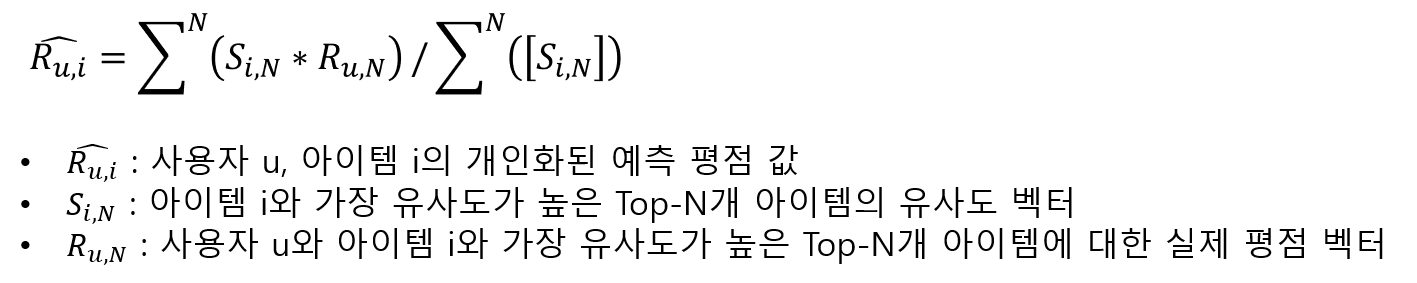

In [57]:
# ratings_arr : 사용자-영화 평점 넘파이 행렬(rating_matrix 변환)
# item_sim_arr : 영화 간의 유사도를 가지는 넘파이 행렬(item_sim_df 변환)
# return : 개인화된 예측 평점 계산
def predict_rating(ratings_arr, item_sim_arr ):
  R = ratings_arr
  S = item_sim_arr

  pred = R.dot(S) / np.abs(S).sum(axis=1) 
  return pred

In [58]:
# 개인화된 예측 평점 계산
ratings_pred = predict_rating(ratings_mat.values, item_sim_df.values)
ratings_pred[:3]

array([[0.07034471, 0.5778545 , 0.32169559, ..., 0.13602448, 0.29295452,
        0.72034722],
       [0.01826008, 0.04274424, 0.01886104, ..., 0.02452792, 0.01756305,
        0.        ],
       [0.01188449, 0.03027871, 0.06443729, ..., 0.00922874, 0.01041982,
        0.08450144]])

In [59]:
ratings_pred_mat = pd.DataFrame(ratings_pred,index=ratings_mat.index, columns=ratings_mat.columns)

ratings_pred_mat.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,0.119402,0.185026,0.269199,0.521031,0.141683,0.116623,0.135441,0.224885,0.226528,0.113608,0.185277,0.303638,0.113608,0.255040,0.260446,0.326968,0.305769,0.155031,0.348717,0.186870,0.119402,0.099756,0.206331,0.348717,0.267407,0.237128,0.050947,0.050947,0.200747,0.156893,...,0.186554,0.050947,0.040443,0.121184,0.178482,0.104488,0.104488,0.110808,0.102542,0.175859,0.179162,0.231606,0.093467,0.094357,0.112690,0.113608,0.164231,0.086360,0.277215,0.262709,0.180320,0.112690,0.111653,0.130131,0.248312,0.132009,0.285913,0.113608,0.155861,0.155927,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,0.000000,0.005220,0.093722,0.000000,0.014296,0.016398,0.043685,0.019004,0.020071,0.015640,0.028349,0.043477,0.015640,0.019634,0.016893,0.008251,0.010919,0.013711,0.000000,0.020300,0.000000,0.002726,0.022639,0.000000,0.032268,0.031130,0.040699,0.040699,0.024950,0.043495,...,0.021269,0.040699,0.030610,0.019721,0.002215,0.023352,0.023352,0.028403,0.002314,0.006791,0.033143,0.010933,0.018806,0.003525,0.011425,0.015640,0.030904,0.017290,0.019250,0.039449,0.038895,0.011425,0.035400,0.038101,0.034181,0.026764,0.000000,0.015640,0.037980,0.006859,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,0.091413,0.007483,0.018710,0.080626,0.006995,0.006766,0.006988,0.005427,0.006743,0.006923,0.005389,0.008943,0.006923,0.008559,0.009333,0.006316,0.031652,0.007376,0.009832,0.022056,0.091413,0.002548,0.008762,0.009832,0.008773,0.004379,0.001117,0.001117,0.007007,0.005163,...,0.008810,0.001117,0.000000,0.010758,0.007362,0.003726,0.0

* 기존에 영화를 관람하지 않아 0에 해당했던 부분에 값이 부여되는 경우가 발생

* 내적 결과를 코사인 유사도 벡터 합으로 나누었기 때문에 에측 평점이 실제 평점에 비해 작을 수 있음

In [64]:
# 기존에 평점이 부여된 데이터에 대해 오차 정도를 측정
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE 를 구함. 
def get_mse(pred, actual):

  pred = ratings_pred
  actual = ratings_mat.values

  pred = pred[actual.nonzero()].flatten()
  actual = actual[actual.nonzero()].flatten()

  return mean_squared_error(actual,pred)


In [65]:
get_mse(ratings_pred,ratings_mat.values)

9.895354759094706

* 실제 값과 예측값의 스케일이 다르기 때문에 MSE가 클 수도 있음
 > 중요한 것은 MSE를 감소기키는 방향으로 개선하는 것

In [77]:
def predict_rating(ratings_arr, item_sim_arr ):
  R = ratings_arr
  S = item_sim_arr

  pred = R.dot(S) / np.abs(S).sum(axis=1)
  return pred

In [78]:
# 많은 유사도 벡터 이용으로 인해 예측 성능이 떨어짐
# 특정 영화와 가장 비슷한 유사도를 가지는 영화에 대해서만 유사도 벡터를 적용
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
  pred = np.zeros(ratings_arr.shape)
  # print( pred.shape )

  for col in range(ratings_arr.shape[1]):
    top_n_tiems = item_sim_arr[:, col].argsort()[:-n-1:-1]

    for row in range(ratings_arr.shape[0]):
      R = ratings_arr[row, :][top_n_tiems]
      S = item_sim_arr[col, :][top_n_tiems]
      pred[row, col] = R.dot(S) / np.sum( np.abs(S) )

  return pred

In [79]:
ratings_pred2 = predict_rating_topsim( ratings_mat.values, item_sim_df.values, 20)
get_mse(ratings_pred2, ratings_mat.values)

9.895354759094706

* predict_rating_topsim 함수는 predict_rating 함수와 유사하지만 N 인자를 가지고 있어서 TOP-N 유사도를 가지는 영화 유사도 벡터만 예측값을 계산하는 데 적용

* 개별 에측값을 구하기 위해 형, 열 별로 루프를 반복하기 때문에 수행 시간이 오래 걸림

In [75]:
# 실제 평점과의 MSE를 비교
# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred2_mat = pd.DataFrame(ratings_pred2, 
                                 index=ratings_mat.index, 
                                 columns=ratings_mat.columns)

ratings_pred2_mat.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.372406,0.0,0.0,0.0,0.0,1.424705,1.619797,0.0,0.140655,0.0,0.389949,0.0,0.0,0.0,0.0,0.389949,1.325574,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.220798,0.0,0.0,1.677291,0.284372
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214767,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.215741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.690974,0.0,0.0,0.0,0.184568,0.0,0.0,0.0,0.251546,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.052784,0.0,0.000000,0.0,0.010994,0.0,0.0,0.0,0.0,0.010994,0.022992,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


특정 사용자에 대해 영화를 추천 (userId = 9)

In [76]:
# 어떤 영화를 좋아하는지 확인
# 사용자 평점을 준 영화를 평점이 높은 순으로 나열
user_id = ratings_mat.loc[9,:]
user_id[user_id > 0].sort_values(ascending=False)[:10]

title
Adaptation (2002)                                                                 5.0
Austin Powers in Goldmember (2002)                                                5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Producers, The (1968)                                                             5.0
Citizen Kane (1941)                                                               5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Back to the Future (1985)                                                         5.0
Glengarry Glen Ross (1992)                                                        4.0
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)                                     4.0
Name: 9, dtype: float64

아이템 기반 협업 필터링을 통해 영화를 추천

In [82]:
# 사용자가 이미 평점을 준 영화를 제외하고 추천할 수 있도록
#  평점을 주지 않은 영화를 리스트 객체로 반환하는 함수
def get_unseen_movies(ratings_matrix, userId):
  user_id = ratings_mat.loc[userId,:]
  return user_id[user_id<=0].index.values.tolist()

unseen_list = get_unseen_movies(ratings_mat, 9)

In [86]:
# 아이템 기반 협업 필터링을 통해 영화를 추천
# pred_df : 예측 평점 DataFrame
# userId : 사용자 id
# unseen_list : 추천 후보 영화 리스트
# top_n : 추천 상위 영화 개수
# return : 사용자가 좋아할 만한 가장 높은 예측 평점을 가진 영화 추천
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    return pred_df.loc[userId,unseen_list].sort_values(ascending=False)[:top_n]

recomm_movie_by_userid(ratings_pred2_mat,9,unseen_list,10)


# 사용자가 관람하지 않는 영화명 추출   
# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천 
# 평점 데이타를 DataFrame으로 생성. 

title
Shrek (2001)                                                                                      0.866202
Spider-Man (2002)                                                                                 0.857854
Last Samurai, The (2003)                                                                          0.817473
Indiana Jones and the Temple of Doom (1984)                                                       0.816626
Matrix Reloaded, The (2003)                                                                       0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)    0.765159
Gladiator (2000)                                                                                  0.740956
Matrix, The (1999)                                                                                0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003)                                     0.689591
Lord of the Rings: The Return o

## 잠재 요인 협업 필터링

* 사용자-아이템 평점 매트릭스 속에 숨어 있는 잠재 요인을 추출해 추천 예측을 하는 것

* 행렬분해 : 대규모 다차원 행렬을 SVD와 같은 차원 감소 기법으로 분해하는 과정에서 잠재 요인을 추출하는 것

 - 분해(Factorization) : 인수분해, 하나의 복잡한 다항식을 두 개 이상의 좀 더 단순한 인수(factor)의 곱으로 분해하는 것
 ```
x^2 + 5x + 6 = (x + 2)(x + 3)
 ```

### 경사하강을 이용한 행렬 분해

* 행렬분해에 주로 사용되는 SVD는 널(NaN) 값이 없는 행렬에만 적용 가능

* 이러한 경우 확률적 경사 하강법(SGD) 또는 ALS(Alternating Least Squares) 방식을 이용하여 SVD 를 수행

확률적 경사 하강법을 이용한 행렬 분해의 절차

1. P와 Q 행렬을 임의의 값을 가진 행렬로 초기화 한다.
2. P와 Q 전치행렬을 곱해 예측 R 행렬을 계산하고, 실제 R 행렬과의 차이를 계산한다.
3. 차이를 최소화할 수 있도록 P와 Q 행렬의 값을 적절한 값으로 각각 업데이트한다.
4. 특정임계치 아래로 수렴할 때까지 2, 3번 작업을 반복하면서 P와 Q 행렬을 업데이트해 근사화한다.



In [ ]:
import numpy as np

# 원본 행렬 R 생성, 분해 행렬 P와 Q 초기화, 잠재요인 차원 K는 3 설정. 
R = np.array([[4, np.NaN, np.NaN, 2, np.NaN ],
              [np.NaN, 5, np.NaN, 3, 1 ],
              [np.NaN, np.NaN, 3, 4, 4 ],
              [5, 2, 1, 2, np.NaN ]])
num_users, num_items = R.shape
K=3

# P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 random한 값으로 입력합니다. 
np.random.seed(1)
P = np.random.normal(scale=1./K, size=(num_users, K))
Q = np.random.normal(scale=1./K, size=(num_items, K))

get_rmse 함수 작성하여 차이 계산

* 실제 R 행렬과 예측 R 행렬과의 차이를 계산하고, 확률적 경사 하강법의 2에서 3번 과정을 1000번 반복수행하여 P와 Q 행렬을 업데이트한다. 이때 학습률은 0.01 이며, L2 정규화 계수는 0.01 로 설정

In [ ]:
# 실제 행렬과 예측 행렬의 오차를 구하는 함수 실제 행렬과 예측 행렬의 오차를 구하는 함수
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
  # 두개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
  # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
  pass


In [ ]:
# R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트에 저장
# SGD 기법으로 P와 Q 매트릭스를 계속 업데이트


이렇게 분해된 P와 Q 행렬을 내적하여 예측 행렬을 만들 수 있고, 실제 행렬과 비교한 결과


In [ ]:
# 실제 행렬
# 예측 행렬


## 행렬 분해 기반의 잠재 요인 협업 필터링

행렬 분해를 이용한 개인화 영화 추천시스템 개발

* 다차원 희소 행렬인 사용자-아이템 행렬 데이터를 저차원 밀집 행렬의 사용자-잠재요인 행렬과 아이템-잠재요인 행렬의 전치 행렬로 분해(잠재요인-아이템 행렬)

* 두 행렬의 내적을 통해 새로운 예측 사용자-아이템 평점 행렬 데이터를 만들어서 사용자가 아직 평점을 부여하지 않는 아이템에 대한 예측 평점을 생성하는 것

MovieLens 데이터 세트

* https://grouplens.org/datasets/movielens/latest/

 * ml-latest-small.zip (size: 1 MB) : 십만개의 평점(rating) 정보

* 앞서 나온 MovieLens의 데이터셋을 가지고 SGD 기반으로 행렬 분해를 구현, 이를 통해 사용자에게 영화를 추천

* 위에서 언급한 RMSE 계산 함수를 그대로 사용하고, SGD 기반의 행렬 분해 시 200번의 반복계산, 학습률을 0.01, L2 정규화 계수를 0.01 로 설정하고 P와 Q 행렬을 계산

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
  # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
  # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
  pass

In [ ]:
# 행렬분해
# R : 원본 사용자-아이템 평점 행렬
# K : 잠재 요인의 차원 수
# steps : SGD의 반복 횟수
# learning_rate : 학습률
# r_lambda : L2 규제
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    pass

In [ ]:
import pandas as pd
import numpy as np

# 사용자-아이템 평점 행렬로 로드
# title 컬럼을 얻기 이해 movies 와 조인 수행
# columns='title' 로 title 컬럼으로 pivot 수행

계산된 예측 R 행렬을 쉽게 이해하기 위해 사용자-아이템 평점 행렬을 영화 타이틀을 칼럼명으로 가지는 DataFrame으로 변경하고 출력

In [ ]:
# 쉽게 영화 아이템 칼럼을 이해하기 위해 에측 사용자-아이템 평점 행렬을
#  영화 타이틀 칼럼명으로 가지는 DataFrame으로 변경


* 만들어진 예측 사용자-아이템 평점 행렬 정보를 이용해 개인화된 영화 추천을 진행

* 잠재요인 협업 필터링에서 이미 만들어진 get_unseen_movies(), recomm_movie_by_userid() 를 다시 이용하여 추천 영화를 추출

In [ ]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함. 
    pass

In [ ]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함. 
    pass

In [ ]:
# 사용자가 관람하지 않는 영화명 추출   
# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천 
# 평점 데이타를 DataFrame으로 생성. 


## 파이썬 추천 시스템 패키지 - Surprise

* 추천 시스템의 전반적인 알고리즘을 이해하고 사이킷런 사용 경험이 있으면 쉽게 사용 가능

In [ ]:
!pip install surprise

In [ ]:
import surprise 

print(surprise.__version__)

### Surprise 를 이용한 추천 시스템 구축

In [ ]:
from surprise import SVD
from surprise import Dataset 
from surprise import accuracy 
from surprise.model_selection import train_test_split

In [ ]:
data = Dataset.load_builtin('ml-100k') 

### Surprise 주요 모듈 소개

In [ ]:
import pandas as pd

ratings = pd.read_csv(drive_path + 'ml-latest-small/ratings.csv')
# ratings_noh.csv 파일로 unload 시 index 와 header를 모두 제거한 새로운 파일 생성.  


In [ ]:
from surprise import Reader


In [ ]:
import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv(drive_path + 'ml-latest-small/ratings.csv') 
reader = Reader(rating_scale=(0.5, 5.0))



### 교차 검증(Cross Validation)과 하이퍼 파라미터 튜닝

In [ ]:
from surprise.model_selection import cross_validate 

# Pandas DataFrame에서 Surprise Dataset으로 데이터 로딩 
ratings = pd.read_csv(drive_path + 'ml-latest-small/ratings.csv') # reading data in pandas df
reader = Reader(rating_scale=(0.5, 5.0))


In [ ]:
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터들을 딕셔너리 형태로 지정. 
param_grid = {'n_epochs': [20, 40, 60], 'n_factors': [50, 100, 200] }

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse 로 수행 하도록 GridSearchCV 구성
# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터


### Surprise 를 이용한 개인화 영화 추천 시스템 구축

In [ ]:
# 아래 코드는 train_test_split( )으로 분리되지 않는 Dataset에 fit( )을 호출하여 오류를 발생
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
algo = SVD(n_factors=50, random_state=0)
algo.fit(data)


AttributeError: ignored

In [ ]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성. 
data_folds = DatasetAutoFolds(ratings_file=drive_path+'ml-latest-small/ratings_noh.csv', reader=reader)

#전체 데이터를 학습데이터로 생성함. 
trainset = data_folds.build_full_trainset()


In [ ]:
# 영화에 대한 상세 속성 정보 DataFrame로딩
# userId=9 의 movieId 데이터 추출하여 movieId=42 데이터가 있는지 확인. 


In [ ]:
def get_unseen_surprise(ratings, movies, userId):
    pass

unseen_movies = get_unseen_surprise(ratings, movies, 9)

In [ ]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
    pass

unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)
print('##### Top-10 추천 영화 리스트 #####')
